<a href="https://colab.research.google.com/github/kamnsv/hackaton/blob/main/%D0%A0%D0%B5%D1%88%D0%B5%D0%BD%D0%B8%D0%B5%20%D1%82%D0%B5%D1%81%D1%82%D0%BE%D0%B2%D0%BE%D0%B3%D0%BE%20%D0%B7%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D1%8F%20%D0%A3%D0%98%D0%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Имеется табличный датасет:

# Данные

In [ ]:
#@title Импорт библиотеки
import os
import gdown
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # Для отрисовки графиков
import seaborn as sns           # Расширние отрисовки графиков
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.preprocessing import image # для отрисовки изображения
from tensorflow.keras.optimizers import Adam # загружаем выбранный оптимизатор
from tensorflow.keras import utils # загружаем утилиты кераса
from google.colab import drive # подключаем гугл драйв диск для загрузки файлов
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title Загрузка базы
fname = gdown.download('https://storage.yandexcloud.net/aiueducation/temp/data.csv', None)

Downloading...
From: https://storage.yandexcloud.net/aiueducation/temp/data.csv
To: /content/data.csv
100%|██████████| 3.32M/3.32M [00:01<00:00, 3.26MB/s]


In [ ]:
#@title Обзор базы
df = pd.read_csv(fname, index_col=0)
df

,param_1,param_2,param_3,param_4,param_5,param_6,param_7,param_8,target
0,2.453,3.333,4.528,215.902,230.972,27.946,1.952,1.952,80
1,2.465,3.006,4.568,215.407,228.207,26.041,2.441,2.441,80
2,2.466,2.863,4.505,214.687,226.742,24.736,2.611,2.611,80
3,2.454,3.042,4.420,214.914,225.103,24.032,2.285,2.285,80
4,2.446,3.541,4.326,215.854,222.698,24.299,2.391,2.391,80
...,...,...,...,...,...,...,...,...,...
12718,2.727,10.057,3.902,216.315,198.627,18.087,87.569,116.240,4
12719,2.744,10.233,4.154,216.512,199.099,18.275,109.265,118.746,4
12720,2.758,10.448,4.364,216.532,200.427,18.108,130.311,122.066,4
12721,2.761,10.658,4.496,216.137,201.559,18.042,129.043,125.084,4


In [ ]:
df['target'].unique()

array([80,  4,  2])

In [ ]:
df['target'].value_counts()

4     32871
80    15379
2      5046
Name: target, dtype: int64

Датасет включает 8 входных параметров (`param1`...`param_8`) и один целевой (`targer` - 3 возможных значения: 80, 4, 2).

**Требуется** обучить модель предсказания целевого параметра (задача классификации).

*Дополнительно*

Есть возможность расширения исходного датасета за счет измользования погрешности измерения. 

Ниже представлена погрешность измерения для каждого входного параметра:
* `param_1` - 0.1
* `param_2` - 1.5
* `param_3` - 1
* `param_4` - 50
* `param_5` - 20
* `param_6` - 0
* `param_7` - 0
* `param_8` - 0

Это означает, что каждое значение `param_1`, например, может быть скорректировано в диапазоне +-0.1. Т.е. в Вашем распоряжении, по сути, получается безграничный набор данных.

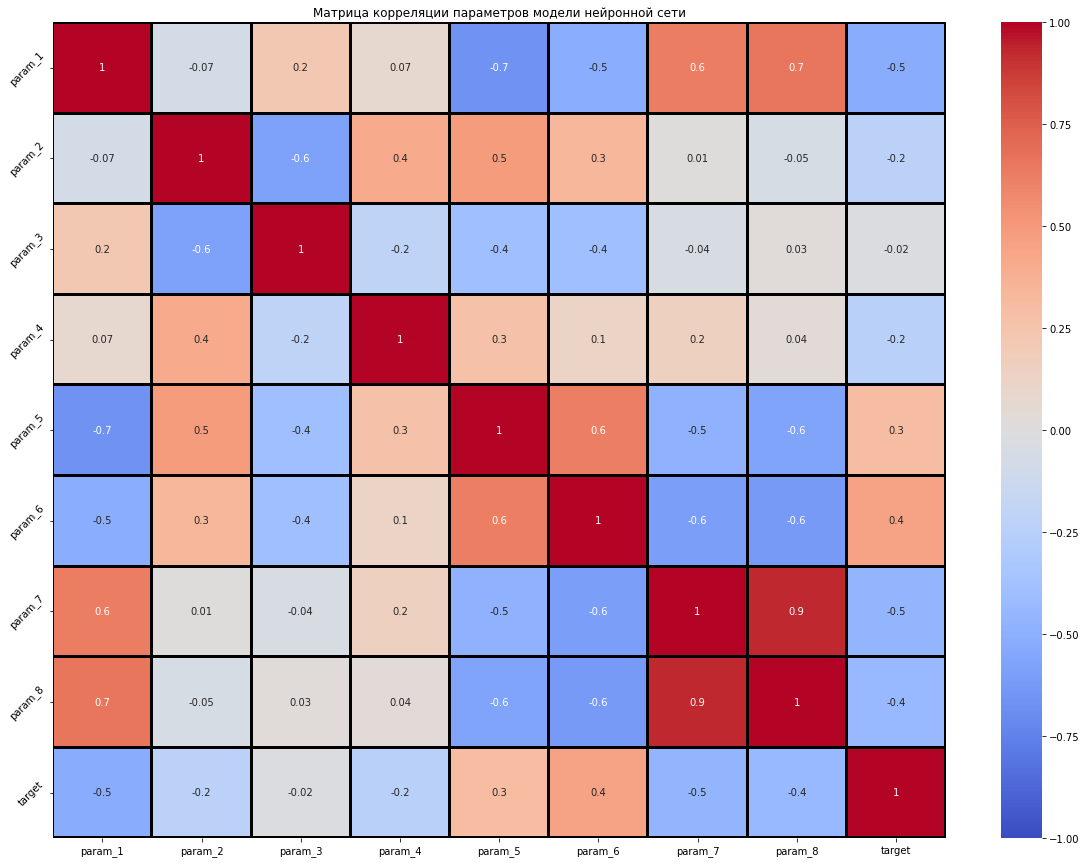

In [ ]:
#@title Матрица корреляции
plt.figure(figsize=(20,15))
plt.title("Матрица корреляции параметров модели нейронной сети")
sns.heatmap(df.corr('spearman'), cmap= 'coolwarm', vmin=-1, center=0, linewidths=2,
            linecolor='black', annot = True, fmt='.1g')  
plt.yticks(rotation=45)
plt.show()

# Выборки

In [ ]:
#@title Обработчик данных
class Dataseter:
  def __init__(self, df, target, scaler):
    self.scaler = scaler
    self.df = df
    self.target = target
    self.x = self.get_x()
    self.y = self.get_y()

  def get_x(self):
    x = None
    for k in self.df:
      if self.target == k: continue
      # [-1; 1]
      xk = np.array(df[k])
      xk = -1 + 2*(xk - self.scaler[k][0])/(self.scaler[k][1] - self.scaler[k][0])
      x = xk if x is None else np.column_stack( [ x , xk ] )
    return x

  def get_y(self):
    self.uniq_target = sorted(np.unique(self.df[self.target].values))
    self.tar_key = {j: i for i, j in enumerate(self.uniq_target)}
    y = np.array([self.tar_key[i] for i in self.df[self.target]])
    return utils.to_categorical( y, len(self.tar_key) )

  def to_target(self, y):
    return self.uniq_target[np.argmax(y)]

  def to_input(self, x, k):
    return self.scaler[k].transform(np.array(x).reshape(-1, 1)).flatten()

  def dataset(self, test_size=0.2): 
    if test_size == 0:
      return self.x, None, self.y, None
    return train_test_split(self.x, self.y, test_size=test_size) 

In [ ]:
#@title Нормализация
scaler = {}
for k in df:
  scaler[k] = (df[k].min(), df[k].max())

In [ ]:
#@title Деление выборок
ds = Dataseter(df, 'target', scaler)
x_train, x_valid, y_train, y_valid = ds.dataset(0.2)
x_train.shape, y_train.shape

((42636, 8), (42636, 3))

In [ ]:
x_train[0], y_train[0]

(array([ 0.28418399, -0.91588785,  0.02290076, -0.94978453, -0.38914851,
        -0.21380662, -0.99998396, -0.99960494]),
 array([0., 0., 1.], dtype=float32))

# Нейросеть

In [ ]:
#@title Модель
model = Sequential([           
    Dense(1024, input_shape = x_train.shape[1:]), 
    Dropout(0.1), 
    Activation('relu'),
    Dense(512), 
    Dropout(0.3), 
    Activation('softplus'),
    BatchNormalization(),
    Dense(1024), 
    Dropout(0.3), 
    Activation('relu'),
    Dense(3),  
    Activation('softmax')

], name='model_hackaton')

print(model.summary())

Model: "model_hackaton"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 1024)              9216      
                                                                 
 dropout_3 (Dropout)         (None, 1024)              0         
                                                                 
 activation_4 (Activation)   (None, 1024)              0         
                                                                 
 dense_5 (Dense)             (None, 512)               524800    
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 activation_5 (Activation)   (None, 512)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 512)           

In [ ]:
#@title Параметры сети
lr = "0.001" #@param [0.1, 0.01, 0.001, 0.0001, 0.00001]
batch_size = 64  #@param {type:"slider", min:1, max:50000, step:1}
epochs     = 300 #@param {type:"slider", min:1, max:1000, step:1}

In [ ]:
#@title Компиляция
model.compile(loss="categorical_crossentropy", 
              optimizer=Adam(learning_rate=float(lr)), 
              metrics=["accuracy"])

In [ ]:
#@title Колбэки
callback = [ReduceLROnPlateau(monitor='val_accuracy', factor=0.5,
                        patience=5, min_lr=0.0000001, verbose=1)]

In [ ]:
#@title Обучение
h = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
              validation_data = (x_valid, y_valid), callbacks=callback)

Epoch 1/300
667/667 [==============================] - 21s 30ms/step - loss: 0.5003 - accuracy: 0.8109 - val_loss: 0.4904 - val_accuracy: 0.8096 - lr: 0.0010
Epoch 2/300
667/667 [==============================] - 22s 32ms/step - loss: 0.4455 - accuracy: 0.8293 - val_loss: 0.4388 - val_accuracy: 0.8202 - lr: 0.0010
Epoch 3/300
667/667 [==============================] - 18s 27ms/step - loss: 0.4333 - accuracy: 0.8343 - val_loss: 0.3911 - val_accuracy: 0.8506 - lr: 0.0010
Epoch 4/300
667/667 [==============================] - 18s 27ms/step - loss: 0.4178 - accuracy: 0.8370 - val_loss: 0.4037 - val_accuracy: 0.8481 - lr: 0.0010
Epoch 5/300
667/667 [==============================] - 18s 28ms/step - loss: 0.4087 - accuracy: 0.8414 - val_loss: 0.3689 - val_accuracy: 0.8586 - lr: 0.0010
Epoch 6/300
667/667 [==============================] - 18s 27ms/step - loss: 0.4030 - accuracy: 0.8432 - val_loss: 0.4103 - val_accuracy: 0.8300 - lr: 0.0010
Epoch 7/300
667/667 [==============================]

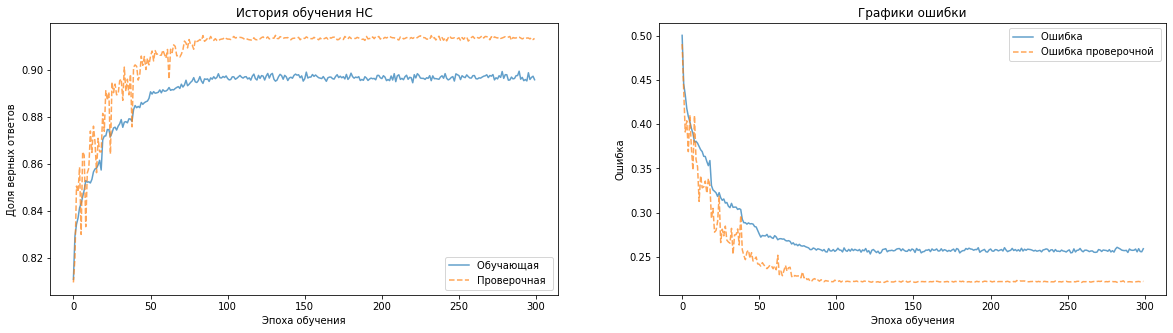

In [ ]:
#@title Графики 
def draw_fit(h):  
  plt.figure(figsize=(20,5))

  plt.subplot(121)
  plt.title('История обучения НС')

  # Выводим график точности обучения
  plt.plot(h.history['accuracy'], label = 'Обучающая ', alpha=0.7)

  # Выводим график точности проверки
  plt.plot(h.history['val_accuracy'], label = 'Проверочная ', 
           linestyle = '--', alpha=0.7)
    
  # Выводим подписи осей
  plt.xlabel('Эпоха обучения')  
  plt.ylabel('Доля верных ответов')
  # Выводим легенду
  plt.legend()

  # Выводим графики ошибки
  plt.subplot(122)
  plt.title('Графики ошибки')
  # Выводим график ошибки 
  plt.plot(h.history['loss'], 
          label='Ошибка ', alpha=0.7)
  
  # Выводим график ошибки проверки
  plt.plot(h.history['val_loss'], 
          label = 'Ошибка проверочной ', 
          linestyle = '--', alpha=0.7)
    
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Ошибка')
  plt.legend()

  plt.show()

draw_fit(h)

# Тест

**Желаемое значение метрики `accuracy`: (*на тестовом наборе*):** 90%


**Запрещено** добавлять тестовый набор в обучающий набор данных. При обнаружении данного факта - участник будет дисквалифицирован.

In [ ]:
# Тестовый набор

In [ ]:
test_file = gdown.download('https://storage.yandexcloud.net/aiueducation/temp/test_data.csv', None)

Downloading...
From: https://storage.yandexcloud.net/aiueducation/temp/test_data.csv
To: /content/test_data.csv
100%|██████████| 204k/204k [00:00<00:00, 442kB/s]


In [ ]:
test_df = pd.read_csv(test_file, index_col=0)

In [ ]:
test_df.head()

,param_1,param_2,param_3,param_4,param_5,param_6,param_7,param_8,target
0,"2,561","0,949","4,865","215,879","179,872","10,395","362,586","68,346",4
1,"2,572","1,018","4,712","215,799","179,86","9,948","260,96","59,973",4
2,"2,572","1,042","4,002","215,439","178,93","9,535","227,902","47,447",4
3,"2,561","0,896","3,424","215,279","179,869","9,518","214,517","40,465",4
4,"2,546","0,779","4,122","216,409","184,106","9,864","205,179","41,604",80


Финальное решение может быть оформлено в одном из двух вариантов:
1. **Минимальный** Ноутбук с полученным результат, включающий этап подготовки данных, обучения модели, тестирования на тестовом наборе (весь список экспериментов не требуется, только лучшая модель)

2. **Рекомендуемый** Веб-сервис, предоставляющий API. На вход подается 8 входных параметров, в ответ возвращается целевое значение.

In [ ]:
ds.df = test_df
x_test, _, y_test, _ = ds.dataset()

In [ ]:
#@title Оценка
print('Обучающая выборка:')
model.evaluate(x_train, y_train, verbose=1)
print('Поверочная выборка:')
model.evaluate(x_valid, y_valid, verbose=1)
print('Тестовая выборка:')
s = model.evaluate(x_test, y_test, verbose=1)

Обучающая выборка:
1333/1333 [==============================] - 7s 5ms/step - loss: 0.2157 - accuracy: 0.9148
Поверочная выборка:
334/334 [==============================] - 2s 6ms/step - loss: 0.2222 - accuracy: 0.9134
Тестовая выборка:
1333/1333 [==============================] - 7s 5ms/step - loss: 0.2182 - accuracy: 0.9138


# Экспорт

In [ ]:
#@title Сохранение весов
model.save_weights('/content/drive/MyDrive/AI/hack_weights3.h5')

In [ ]:
#@title Конвертация в модуль c++
os.system(f'cp /content/drive/MyDrive/AI/clonevart/keras2cpp.py  keras2cpp.py') 
from keras2cpp import export_model
export_model(model, '/content/drive/MyDrive/AI/hack3.model')

## API сервис
[Это ссылка на сервис](https://kamnsv.com/)